# HIDDEN MARKOV NEURAL NETWORK: MNIST example- Evolving classifier

We study the performance of HMNN on an evolving in time labeller, which artificially generated from the MNIST dataset.

## Import libraries

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import pickle

import gzip

import numpy as np
import random

## Data processing

In [125]:
# Set the seed to guarantee reproducibility
seed_number = 123

random.seed(seed_number)
torch.manual_seed(seed_number)
np.random.seed(seed_number)

The files "train-labels-idx1-ubyte.gz" and "train-images-idx3-ubyte.gz" can be downloaded from:

- http://yann.lecun.com/exdb/mnist/

In [126]:
def load_mnist():
    """Load MNIST data from `path`"""
    labels_path = 'train-labels-idx1-ubyte.gz'
    images_path = 'train-images-idx3-ubyte.gz'
        
    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, 
                               dtype=np.uint8).reshape(
            len(labels), 784).astype(np.float64)
 
    return images, labels

def mnist_preprocessing(x, y, sample_N = 300000, test_ratio = 0.3):

    x = np.float32(x) / 126.
    #np.save("mnist_preprocessed_data", x)
    y = np.int32(y)
    #np.save("mnist_preprocessed_target", y)
    idx = np.random.choice(x.shape[0], sample_N)
    x = x[idx]
    y = y[idx]

    tr_idx, te_idx = train_test_split(np.arange(sample_N), test_size = test_ratio)
    tr_x, te_x = x[tr_idx], x[te_idx]
    tr_y, te_y = y[tr_idx], y[te_idx]

    return tr_x,te_x,tr_y,te_y

In [127]:
x,y = load_mnist()
tr_x, te_x, tr_y, te_y = mnist_preprocessing(x, y)

In [128]:
tr_x = tr_x[0:,:]
tr_y = tr_y[0:]

In [129]:
np.size(tr_y, 0)

210000

## Evolving classifier

### Probability evolution

Probability $f_t$ of choosing classifier $\mathcal{C}_1$.

In [130]:
%matplotlib inline

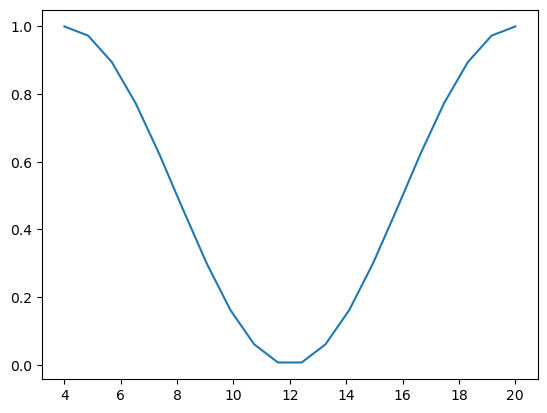

In [131]:
import matplotlib.pyplot as plt

p_grid = 0.5*np.sin(np.pi/8*np.linspace(4, 20, 20))+0.5

plt.plot(np.linspace(4, 20, 20), p_grid)
plt.show()

### Classifier

Set up the dataset by changing the labels according to probabilit $f_t,1-f_t$ and $\mathcal{C}_1,\mathcal{C}_2$ 

In [132]:
class_1 = np.linspace(0, 9, 10).astype(int)
class_2 = (class_1+1)%10

In [133]:
total_size_tr  = 100000
total_size_val = 100000

tr_x_tr = np.copy(tr_x[0:total_size_tr, :])
tr_y_tr = np.copy(tr_y[0:total_size_tr])

tr_x_val = np.copy(tr_x[total_size_tr:total_size_tr+total_size_val, :])
tr_y_val = np.copy(tr_y[total_size_tr:total_size_tr+total_size_val])

In [134]:
trace_tr = (tr_y_tr==0)
trace_val = (tr_y_val==0)

In [135]:

task_size_tr = 5000
task_size_val = 5000

for t in range(0,20):
    j = 0 
    
    trace_class_tr  = list()
    trace_class_val = list()
    for trace_index in range(0,10):
        trace_class_tr.append(tr_y_tr[t*task_size_tr:(t+1)*task_size_tr] == trace_index)
        trace_class_val.append(tr_y_val[t*task_size_val:(t+1)*task_size_val] == trace_index)
        
    for i in class_2:
        coins_tr  = np.random.uniform(0, 1, np.sum(trace_class_tr[j])) 
        coins_val = np.random.uniform(0, 1, np.sum(trace_class_val[j])) 

        tr_y_tr[t*task_size_tr:(t+1)*task_size_tr][trace_class_tr[j]]   = (coins_tr>= p_grid[t])*int(i) + (coins_tr< p_grid[t])*int(j)
        tr_y_val[t*task_size_val:(t+1)*task_size_val][trace_class_val[j]] = (coins_val>= p_grid[t])*int(i) + (coins_val< p_grid[t])*int(j)
        
        j = j +1
        
        

In [136]:
tr_x_te = tr_x_val
tr_y_te = tr_y_val

The new label is  3
  
The image is 


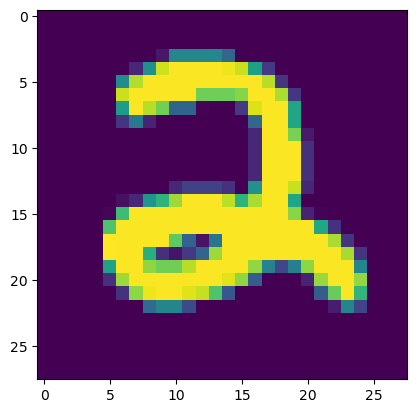

In [137]:
t=5
image = 9
plt.imshow(tr_x_tr[t*task_size_tr:(t+1)*task_size_tr,:][image].reshape(28,28))

print("The new label is ", tr_y_tr[t*task_size_tr:(t+1)*task_size_tr][image])
print("  ")
print("The image is ")

Check the expected $f_t$ on training and validation. We can simply count the number of labels that are zero.

In [138]:
tr_y_val

array([9, 9, 9, ..., 9, 8, 4], dtype=int32)

In [139]:
p_est_tr = np.zeros(20)
p_est_val = np.zeros(20)

for t in range(0,20):
    print(t)
    p_est_tr[t] = np.sum(tr_y_tr[t*task_size_tr:(t+1)*task_size_tr][trace_tr[range(t*task_size_tr,(t+1)*task_size_tr)]]==0)/np.sum(trace_tr[range(t*task_size_tr,(t+1)*task_size_tr)])
    p_est_val[t] = np.sum(tr_y_val[t*task_size_val:(t+1)*task_size_val][trace_val[range(t*task_size_val,(t+1)*task_size_val)]]==0)/np.sum(trace_val[range(t*task_size_val,(t+1)*task_size_val)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


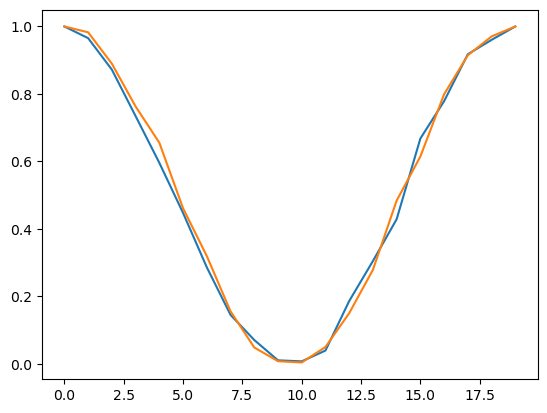

In [140]:
plt.plot(p_est_tr)
plt.plot(p_est_val)
plt.show()

## HMNN

### Set the hyper parameters for the training

In [141]:
# The sample size
sample_size    = 5000
# The minibatch size
minibatch_size = 128
# The number of epochs

epocs          = 10 #Optimal value 600
# This parameter if use to retrain on part of the previous data. 
# If sliding = sample_size then we move to a new set of data.
sliding = 5000
# Number of Sequential training we want to do minus 1
T = 20

###########################################################
# Set the network structure
# Depth
L = 4
# Structure of the hidden units
architecture = np.array([784, 100, 100, 10])

# Kernel parameter of the HMNN
alpha_k = 0.5
sigma_k = np.exp(-2)
c       = np.exp(5)
pi      = 0.5

# Mixture weight for the variational dropconnect
p       = 0.8

# Learning rate
lr_c = 1e-3

# Size of the Monte Carlo sample
mc_c = 1

### Training procedure

In [142]:
%run -i BayesianNetwork.py

<Figure size 640x480 with 0 Axes>

In [143]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss(reduction = 'sum')


HMMNET = torchHHMnet(architecture, alpha_k, sigma_k, c, pi, p, loss_function, sample_size, minibatch_size, epocs, T, sliding, workers = 4)

HMMNET.forward_pass(tr_x_tr, tr_y_tr, tr_x_val, tr_y_val, lr_c, mc_c)

Time  1
Epoch  1


Prior score  2442.25425976001  and Data score  314.5971056791724
Performance on the validation set  0.1484
Epoch  2
Prior score  2440.1494557851324  and Data score  297.1795784799544
Performance on the validation set  0.3132
Epoch  3
Prior score  2438.065460943181  and Data score  273.3352001887598
Performance on the validation set  0.3408
Epoch  4
Prior score  2431.374006530052  and Data score  222.64414834545272
Performance on the validation set  0.492
Epoch  5
Prior score  2425.9821407873196  and Data score  201.34138214785207
Performance on the validation set  0.5392
Epoch  6
Prior score  2424.7839616351944  and Data score  166.53522746170103
Performance on the validation set  0.6856
Epoch  7
Prior score  2418.955057502707  and Data score  144.658350975705
Performance on the validation set  0.777
Epoch  8
Prior score  2415.0977093016722  and Data score  129.22272004266947
Performance on the validation set  0.7756
Epoch  9
Prior score  2409.9446917994014  and Data score  114.9880660

### Validation and Test procedure

Divide in validation and test

In [145]:
task_size_val = 5000

tr_x_test = np.zeros((int(task_size_val/2)*19, 784))
tr_y_test = np.zeros((int(task_size_val/2)*19))

tr_x_val = np.zeros((int(task_size_val/2)*19, 784))
tr_y_val = np.zeros((int(task_size_val/2)*19))

for t in range(0, 19):
#     print(t)
    tr_x_val[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2),:]  = tr_x_te[(t)*task_size_val:(t)*task_size_val+int(task_size_val/2),:]
    tr_x_test[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2),:] = tr_x_te[(t)*task_size_val+int(task_size_val/2):(t+1)*task_size_val,:]
    
    tr_y_val[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2)]  = tr_y_te[(t)*task_size_val:(t)*task_size_val+int(task_size_val/2)]
    tr_y_test[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2)] = tr_y_te[(t)*task_size_val+int(task_size_val/2):(t+1)*task_size_val]   

Validation plot

In [156]:
val_performance = np.zeros(19)
task_size_val = 2375
for t in range(0,19):
    y_predicted     = np.zeros(len(tr_y_val[t*task_size_val:(t+1)*task_size_val]))

    output           = HMMNET.model_list[t+1].performance( torch.tensor( tr_x_val[t*task_size_val:(t+1)*task_size_val,:], dtype = torch.float64 ) )
    output_softmax   = F.softmax(output, dim=1)

    y_predicted = np.array( range(0, 10) )[ np.argmax( output_softmax.data.numpy(), 1 ) ]

    val_performance[t] = sum(tr_y_val[t*task_size_val:(t+1)*task_size_val] == y_predicted)/len(tr_y_val[t*task_size_val:(t+1)*task_size_val])

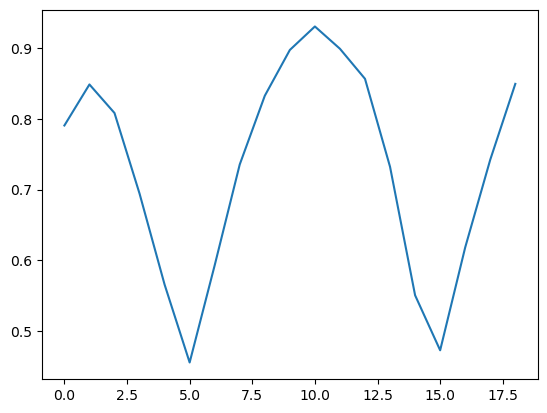

In [157]:
plt.plot(val_performance)
plt.show()

Test performance (mean over time of the accuracy)

In [159]:
test_performance = np.zeros(19)
task_size_test = 2375

for t in range(0,19):
    y_predictestd     = np.zeros(len(tr_y_test[t*task_size_test:(t+1)*task_size_test]))

    output           = HMMNET.model_list[t+1].performance( torch.tensor( tr_x_test[t*task_size_test:(t+1)*task_size_test,:], dtype = torch.float64 ) )
    output_softmax   = F.softmax(output, dim=1)

    y_predicted = np.array( range(0, 10) )[ np.argmax( output_softmax.data.numpy(), 1 ) ]

    test_performance[t] = sum(tr_y_test[t*task_size_test:(t+1)*task_size_test] == y_predicted)/len(tr_y_test[t*task_size_test:(t+1)*task_size_test])

print("Performance on the test set ", np.mean(test_performance))

Performance on the test set  0.7285983379501385


## Bayes by Backprop on the whole dataset

### Set the hyper parameters for the training

In [160]:
# The sample size
sample_size    = 200000
# The minibatch size
minibatch_size = 128
# The number of epochs

epocs          = 10 #Optimal value 600
# This parameter if use to retrain on part of the previous data. 
# If sliding = sample_size then we move to a new set of data.
sliding = 0
# Number of Sequential training we want to do
T = 1

###########################################################
# Set the network structure
# Depth
L = 4
# Structure of the hidden units
architecture = np.array([784, 100, 100, 10])

# Kernel parameter of the HMNN
alpha_k = 0.0
sigma_k = np.exp(-2)
c       = np.exp(5)
pi      = 0.5

# Mixture weight for the variational dropconnect
p       = 0.8

# Learning rate
lr_c = 1e-3

# Size of the Monte Carlo sample
mc_c = 1

### Training procedure

In [161]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss(reduction = 'sum')


HMMNET_nokernel = torchHHMnet(architecture, alpha_k, sigma_k, c, pi, p, loss_function, sample_size, minibatch_size, epocs, T, sliding, workers = 4)

HMMNET_nokernel.forward_pass(tr_x_tr, tr_y_tr, tr_x_val, tr_y_val, lr_c, 2)

Time  1
Epoch  1
Prior score  24.19114078638536  and Data score  123.64862840554812
Performance on the validation set  0.42566315789473685
Epoch  2
Prior score  24.566326576226786  and Data score  85.34485745248958
Performance on the validation set  0.45606315789473684
Epoch  3
Prior score  24.83292312156443  and Data score  75.39265654916433
Performance on the validation set  0.46581052631578945
Epoch  4
Prior score  25.034105878231674  and Data score  71.1713300293038
Performance on the validation set  0.4672
Epoch  5
Prior score  25.207412131854536  and Data score  68.59660009346774
Performance on the validation set  0.4743578947368421
Epoch  6
Prior score  25.343259704848407  and Data score  66.99991314889151
Performance on the validation set  0.47814736842105265
Epoch  7
Prior score  25.469791920561207  and Data score  65.45908882064168
Performance on the validation set  0.47642105263157897
Epoch  8
Prior score  25.5780713700468  and Data score  64.67058401697908
Performance on th

Test performance (mean over time of the accuracy)

In [162]:
test_performance = np.zeros(19)
task_size_test = 2375

for t in range(0,1):
    y_predictestd     = np.zeros(len(tr_y_test[t*task_size_test:(t+1)*task_size_test]))

    output           = HMMNET_nokernel.model_list[t+1].performance( torch.tensor( tr_x_test, dtype = torch.float64 ) )
    output_softmax   = F.softmax(output, dim=1)

    y_predicted = np.array( range(0, 10) )[ np.argmax( output_softmax.data.numpy(), 1 ) ]

    test_performance[t] = sum(tr_y_test == y_predicted)/len(tr_y_test[t*task_size_test:(t+1)*task_size_test])

print("Performance on the test set ", np.mean(test_performance))

Performance on the test set  0.5033573407202215
